In [25]:
# NAMA : RENOL NINDI KARA NATASASMITA
# ASAL : MAJALENGKA
# EMAIL : renol.mangood@gmail.com

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.
Epoch 1/15
328/328 [==============================] - 50s 149ms/step - loss: 1.0624 - accuracy: 0.4930 - val_loss: 0.3458 - val_accuracy: 0.8881
Epoch 2/15
328/328 [==============================] - 38s 117ms/step - loss: 0.3559 - accuracy: 0.8771 - val_loss: 0.4503 - val_accuracy: 0.9201
Epoch 3/15
328/328 [==============================] - 39s 118ms/step - loss: 0.3764 - accuracy: 0.8747 - val_loss: 0.3197 - val_accuracy: 0.9384
Epoch 4/15
328/328 [==============================] - 39s 120ms/step - loss: 0.2705 - accuracy: 0.9253 - val_loss: 0.1123 - val_accuracy: 0.9555
Epoch 5/15
328/328 [==============================] - 39s 118ms/step - loss: 0.2231 - accuracy: 0.9319 - val_loss: 0.1078 - val_accuracy: 0.9646
Epoch 6/15
328/328 [==============================] - 39s 120ms/step - loss: 0.2324 - accuracy: 0.9334 - val_loss: 0.1587 - val_accuracy: 0.9612
Epoch 7/15
328/328 [===========================

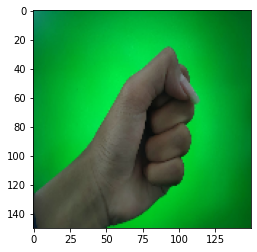

In [2]:
#Extract ZIP

import zipfile, os
import numpy as np
from keras_preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Split Folder
# Untuk Split Folder Disini saya pake library split-folders jadi install terlebih dahulu dengan cara buka cmd lalu ketikan "pip install split-folders"
# untuk rasio nya disoal 60% untuk train dan sisanya 40% untuk validation 
import splitfolders
splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images', output="/tmp/rockpaperscissors/result", seed=1337, ratio=(0.6, 0.4))

# Buat Directory train dan split
base_dir = '/tmp/rockpaperscissors/result'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Membuat Directory RSP pada directory train
train_paper_dir = os.path.join(train_dir, 'paper')
train_rock_dir = os.path.join(train_dir, 'rock')
train_scissors_dir = os.path.join(train_dir, 'scissors')

# Membuat Directory RSP pada directory val
validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

# Membuat Augmentasi gambar

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # direktori data latih
    target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=4,
    # karena kita merupakan masalah klasifikasi 3 kelas atau lebih maka menggunakan class_mode = 'binary'
    class_mode='sparse'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, # direktori data validasi
    target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=4, # karena kita merupakan masalah klasifikasi 3 kelas atau lebih maka menggunakan class_mode = 'sparse'
    class_mode='sparse'
)

# Error pebandingan nya train image 1312 dan val image 876 setelah melihat forum diskusi saya solver menggunakan validation_split di datagen

import tensorflow as tf
# Membangun Arsitektur CNN 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Buat Callback
class callbackFunc(tf.keras.callbacks.Callback):
    def __init__(self, min):
        super(callbackFunc, self).__init__()
        self.min = min

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        acc = logs["accuracy"]
        if val_acc and acc >= self.min:
            self.model.stop_training = True

# Minimum Akurasi 96%
call_back = callbackFunc(min=0.96)

# Compile model dengan RMSDrop optimizer(SARAN) loss function
model.compile(
    loss='sparse_categorical_crossentropy', # binary jika 2 kelas jika 3 kelas atau lebih pake sparse
    optimizer = tf.optimizers.RMSprop(),
    metrics=['accuracy']
)

# latih model dengan model.fit 
model.fit(
    train_generator,
    epochs=15, # tambahkan eposchs jika akurasi model belum optimal
    validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
    verbose=1,
    callbacks=[call_back]
)

# TESTING MENGGUNAKAN IMAGE
import numpy as np
from keras_preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
     
# change it to your filename
fn = 'batu.jpeg'
     
# predicting images
path = fn
img = image.load_img(path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
     
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
output_class = np.argmax(classes)
      
print(fn)
if output_class==0:
    print('paper')
elif output_class==1:
    print('rock')
else:
    print('scissors')